2018 Oct 10<br>
It's clear that my BEER_curve module isn't set up correctly. Specifically, I need to fix the eclipse calculation. This notebook is an attempt to do that.

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import emcee
from emcee.autocorr import integrated_time

from PyAstronomy.modelSuite.XTran.forTrans import MandelAgolLC

import dill

K76 = Kepler76_params()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846897


In [14]:
ma = MandelAgolLC(orbit="circular", ld="quad")
ma["per"] = K76.saved_params["per"]
ma["i"] = 90.#180./np.pi*np.arccos(K76.saved_params["b"]/K76.saved_params["a"])
ma["a"] = K76.saved_params["a"]
ma["T0"] = K76.saved_params["T0"] + 0.5*K76.saved_params["per"]
ma["p"] = K76.saved_params["p"]
ma["linLimb"] = 0.
ma["quadLimb"] = 0.

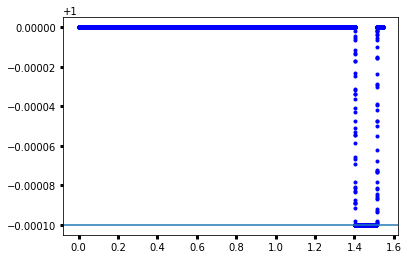

In [18]:
# What I've been calling the eclipse depth
eclipse_depth = 100e-6
ma["p"] = np.sqrt(eclipse_depth)
eclipse = ma.evaluate(folded_time)

normalized_eclipse = eclipse
normalized_eclipse = 1. - normalized_eclipse
normalized_eclipse /= eclipse_depth
normalized_eclipse = 1. - normalized_eclipse

plt.plot(folded_time, eclipse, 'b.')
plt.axhline(1. - eclipse_depth)
#plt.plot(folded_time, normalized_eclipse, 'r.')